Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [16]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
from copy import deepcopy
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass

logging.basicConfig(level=logging.DEBUG)

# Initialization

In [17]:

CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km


DATASETS = {
    'vanuatu': 'cities/vanuatu.csv',
    'italy': 'cities/italy.csv',
    'russia': 'cities/russia.csv',
    'us': 'cities/us.csv',
    'china': 'cities/china.csv'
}

# Function to load cities and compute distance matrix
def load_cities_and_distance_matrix(file_path):
    CITIES = pd.read_csv(file_path, header=None, names=['name', 'lat', 'lon'])
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    return CITIES, DIST_MATRIX


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [18]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

#used while running multiple instances
def tsp_cost_dm(tsp, dist_matrix):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(dist_matrix)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += dist_matrix[c1, c2]
    return tot_cost

def path_cost(edges):
    total_cost = sum(DIST_MATRIX[edge[0], edge[1]] for edge in edges)
    return total_cost

## First Greedy Algorithm
With this approach, starting from an initial node, the nearest node is searched and marked as visited, and this continues until all nodes have been visited.

In [19]:
visited = np.full(len(CITIES), False)
dist = DIST_MATRIX.copy()
city = 0
visited[city] = True
tsp = list()
tsp.append(int(city))
while not np.all(visited):
    dist[:, city] = np.inf
    closest = np.argmin(dist[city])
    logging.debug(
        f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
    )
    visited[closest] = True
    city = closest
    tsp.append(int(city))
logging.debug(
    f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
)
tsp.append(tsp[0])


logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")

DEBUG:root:step: Isangel -> Vila (223.00km)
DEBUG:root:step: Vila -> Lakatoro (206.74km)
DEBUG:root:step: Lakatoro -> Norsup (2.46km)
DEBUG:root:step: Norsup -> Luganville (67.09km)
DEBUG:root:step: Luganville -> Port Olry (52.02km)
DEBUG:root:step: Port Olry -> Longana (105.77km)
DEBUG:root:step: Longana -> Sola (165.49km)
DEBUG:root:step: Sola -> Isangel (652.96km)
INFO:root:result: Found a path of 8 steps, total length 1475.53km


In [20]:
def cyclic(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        nx.find_cycle(G)
        return True
    except:
        return False
        
def is_hamiltonian_cycle(edges, num_nodes):

    G = nx.Graph()
    G.add_edges_from(edges)
    return nx.is_connected(G) and len(edges) == num_nodes and all(deg == 2 for _, deg in G.degree())

def plot_tsp_path(tsp, cities):
    coords = cities[['lon', 'lat']].to_numpy()
    tsp_coords = coords[tsp]
    tsp_coords = np.vstack([tsp_coords, tsp_coords[0]])

    plt.figure(figsize=(10, 6))
    plt.plot(tsp_coords[:, 0], tsp_coords[:, 1], marker='o', color='b')
    
    for i, city in enumerate(tsp[:-1]):
        plt.text(coords[city][0], coords[city][1], cities.at[city, 'name'], fontsize=9, ha='right')

    plt.title('TSP PATH')
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.grid()
    plt.show()


In [21]:
segments = [
    ({c1, c2}, float(DIST_MATRIX[c1, c2])) for c1, c2 in combinations(range(len(CITIES)), 2)
]
visited = set()
visited_second = set()
edges = set()

In [22]:
shortest = next(_ for _ in sorted(segments, key=lambda e: e[1]))


this class is used to identify the edges that can generate internal cycles while added to the path verifyng if the nodes of the edge that we are tryng to add have a common neighbor

In [23]:
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, u):
        if self.parent[u] != u:
            self.parent[u] = self.find(self.parent[u])
        return self.parent[u]

    def union(self, u, v):
        root_u = self.find(u)
        root_v = self.find(v)

        if root_u != root_v:
            if self.rank[root_u] > self.rank[root_v]:
                self.parent[root_v] = root_u
            elif self.rank[root_u] < self.rank[root_v]:
                self.parent[root_u] = root_v
            else:
                self.parent[root_v] = root_u
                self.rank[root_u] += 1
            return True
        return False

As the solution of the second greedy algorithm is a set of edges, to simplify the optimization phase this method generates a path in the form [0,1,2,3,4,0]

In [24]:
def edges_to_sequential_path(edges):
   
    neighbors = {}
    for u, v in edges:
        if u not in neighbors:
            neighbors[u] = []
        if v not in neighbors:
            neighbors[v] = []
        neighbors[u].append(v)
        neighbors[v].append(u)
    
    start_node = next(iter(neighbors))
    path = [start_node]
    current = start_node
    prev = None
    
    while True:
        next_node = next(node for node in neighbors[current] if node != prev)
        path.append(next_node)
        prev, current = current, next_node
        
        if next_node == start_node:
            break

    return path

# Second greedy approach
With this approach, all edges with the shortest path are selected until all nodes have been selected twice, taking care to ensure that a new edge does not create a premature cycle.

In [25]:

edges = set()
uf = UnionFind(len(CITIES))
node_degree = {i: 0 for i in range(len(CITIES))} 
step_count = 0 

while len(edges) < len(CITIES) - 1:
    for segment in sorted(segments, key=lambda e: e[1]):
        step_count+=1
        nodes = list(segment[0])

        if (
            tuple(nodes) not in edges
            and all(node_degree[node] < 2 for node in nodes)
            and uf.union(nodes[0], nodes[1]) 
        ):
            edges.add(tuple(nodes))
            node_degree[nodes[0]] += 1
            node_degree[nodes[1]] += 1

            segments.remove(segment)
            break

end_nodes = [node for node, degree in node_degree.items() if degree == 1]
if len(end_nodes) == 2:
    edges.add((end_nodes[0], end_nodes[1]))


if is_hamiltonian_cycle(edges, len(CITIES)):
    logging.info("valid solution")
else:
    logging.info("the solution is not an hamiltonian cycle")
total_path_cost = path_cost(edges)
path = edges_to_sequential_path(edges)
logging.info(f"Total path cost: {total_path_cost:.2f} km")
logging.info(f"Total steps: {step_count}")


INFO:root:valid solution
INFO:root:Total path cost: 1475.53 km
INFO:root:Total steps: 33


# SIMULATED ANNEALING


In [26]:


def mutate(state):
    
    neighbor = deepcopy(state)
    func = random.choice([0, 1, 2, 3])
    
    if func == 0:
        inverse(neighbor)
    elif func == 1:
        insert(neighbor)
    elif func == 2:
        swap(neighbor)
    else:
        swap_routes(neighbor)
        
    return neighbor

def inverse(state):
    if len(state) > 3:
        node_one = random.randint(1, max(1, len(state) - 2))
        node_two = random.randint(1, max(1, len(state) - 2))
        
        if node_one > node_two:
            node_one, node_two = node_two, node_one
        state[node_one:node_two + 1] = state[node_one:node_two + 1][::-1]
    
    return state

def insert(state):

    if len(state) > 3:
        node_j = random.randint(1, max(1, len(state) - 2))
        city = state.pop(node_j) 
        
        node_i = random.randint(1, max(1, len(state) - 2))
        state.insert(node_i, city)
    
    return state

def swap(state):

    if len(state) > 3:
        pos_one = random.randint(1, max(1, len(state) - 2))
        pos_two = random.randint(1, max(1, len(state) - 2))
        
        while pos_one == pos_two:
            pos_two = random.randint(1, max(1, len(state) - 2))
        
        state[pos_one], state[pos_two] = state[pos_two], state[pos_one]
    
    return state

def swap_routes(state):

    if len(state) > 3:
        subroute_a = random.randint(1, max(1, len(state) - 2))
        subroute_b = random.randint(1, max(1, len(state) - 2))
        
        if subroute_a > subroute_b:
            subroute_a, subroute_b = subroute_b, subroute_a
        
        subroute = state[subroute_a:subroute_b + 1]
        del state[subroute_a:subroute_b + 1]
        
        insert_pos = random.randint(1, max(1, len(state) - 2))
        for city in reversed(subroute):
            state.insert(insert_pos, city)
    
    return state



In [27]:
import math


def annealing(initial_state):
    
    initial_temp = 5000 
    alpha = 0.99
    current_temp = initial_temp
    step_count=0
    solution = initial_state[:]
    best_solution = solution[:]
    best_cost = tsp_cost(solution)
    same_solution = 0
    same_cost_diff = 0
    
    while same_solution < 1500 and same_cost_diff < 30000:
        step_count+=1
        neighbor = mutate(solution)
        
        current_cost = tsp_cost(solution)
        neighbor_cost = tsp_cost(neighbor)
        cost_diff = neighbor_cost - current_cost
 
        if cost_diff < 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff = 0
            
            if neighbor_cost < best_cost:
                best_solution = neighbor
                best_cost = neighbor_cost
            
        elif cost_diff == 0:
            solution = neighbor
            same_solution = 0
            same_cost_diff += 1
            
        else:
            acceptance_probability = math.exp(-cost_diff / current_temp)
            if random.uniform(0, 1) < acceptance_probability:
                solution = neighbor
                same_solution = 0
                same_cost_diff = 0
            else:
                same_solution += 1
                same_cost_diff += 1
                
        current_temp *= alpha
    
    return best_solution, best_cost,step_count





INFO:root:Optimized path: [0, 7, 1, 4, 3, 5, 6, 2, 0]
INFO:root:Optimized path cost: 1345.54km
INFO:root:Total steps: 34438


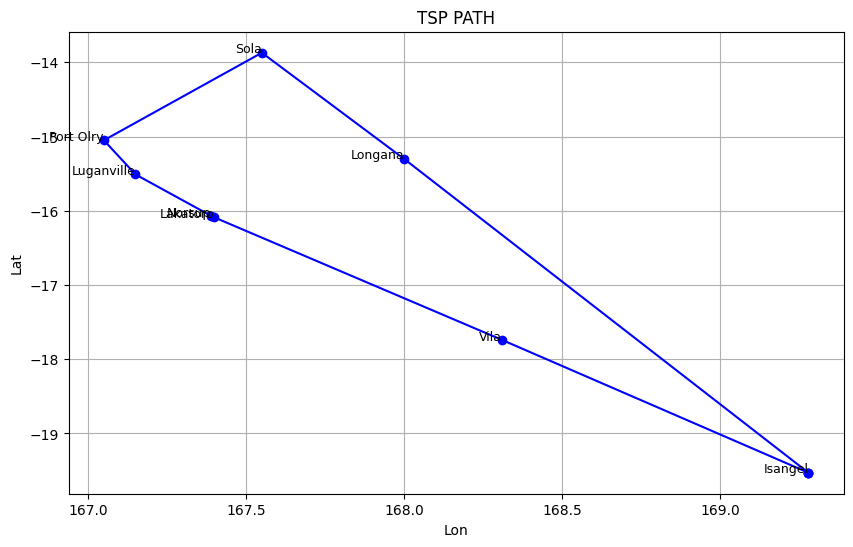

In [28]:

optimized_tsp, optimized_cost,stpC = annealing(path)
logging.info(f"Optimized path: {optimized_tsp}")
logging.info(f"Optimized path cost: {optimized_cost:.2f}km")
logging.info(f"Total steps: {stpC}")
plot_tsp_path(optimized_tsp,CITIES)

# GENETIC ALGORITHM WITH INVER OVER CROSSOVER

In [29]:

POPULATION_SIZE = 500
MUTATION_PROBABILITY = 0.8
CROSSOVER_PROBABILITY = 0.2
RANDOM_INVERSION_PROBABILITY = 0.02

@dataclass
class Individual:
    genome: np.ndarray
    fitness: float = None

def parent_selection(population):
    return min(random.sample(population, 5), key=lambda i: i.fitness)


def inver_over(parent1, parent2, dist_matrix):
    genome1, genome2 = parent1.genome[1:-1], parent2.genome[1:-1]
    i = random.randint(0, len(genome1) - 1)
    p1Gene = genome1[i]
    
    if random.random() < RANDOM_INVERSION_PROBABILITY:
        # Choose c' randomly from remaining cities
        remaining_genes = [gene for gene in genome1 if gene != p1Gene]
        p2Gene = random.choice(remaining_genes)
    else:
        # Select 'next' city from parent2
        j = np.where(np.array(genome2) == p1Gene)[0][0]
        p2Gene = genome2[(j + 1) % len(genome2)]
    

    if abs(genome1.index(p2Gene) - i) == 1:
        return parent1

    flip_genome = np.concatenate([genome1[i:], genome1[:i]])
    cut_point = np.where(flip_genome == p2Gene)[0][0]
    reversed_sequence = flip_genome[1:cut_point][::-1]
    
    offspring_genome = [0] + [int(p1Gene)] + list([int(g) for g in reversed_sequence]) + [int(p2Gene)] + list([int(g) for g in flip_genome[cut_point + 1:]]) + [0]

    offspring = Individual(offspring_genome)
    offspring.fitness = tsp_cost_dm(offspring.genome, dist_matrix)
    
    return offspring if offspring.fitness < parent1.fitness else parent1


In [ ]:

def generate_population(size,cities,dist_matrix):
    population = []
    rng = np.random.default_rng()
    while len(population) < size:
        genome = [0]
        other_cities = list(range(1, len(cities)))
        rng.shuffle(other_cities)
        genome += other_cities + [0]
        individual = Individual(genome, tsp_cost_dm(genome,dist_matrix))
        if all(individual.genome != ind.genome for ind in population):
            population.append(individual)
    return population



def run_genetic_algorithm(dist_matrix, cities):
    
    population = generate_population(POPULATION_SIZE, cities, dist_matrix)
    best_fitness = float('inf')
    no_improvement_count = 0
    cycle_count = 0

    while no_improvement_count < 3000:
        population.sort(key=lambda i: i.fitness)
        new_population = population[:max(int(0.05 * POPULATION_SIZE), int(0.1 * POPULATION_SIZE))]

        while len(new_population) < POPULATION_SIZE:
            parent1 = parent_selection(population)
            if random.random() < CROSSOVER_PROBABILITY:

                parent2 = parent_selection(population)
                offspring = inver_over(parent1, parent2, dist_matrix)

            else:

                offspring = deepcopy(parent1)
                offspring.genome = mutate(offspring.genome)
                
            
            offspring.fitness = tsp_cost_dm(offspring.genome, dist_matrix)
            new_population.append(offspring)

        population = new_population

        
        current_best_fitness = population[0].fitness
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        cycle_count += 1
        logging.debug(f"Generation {cycle_count}: Best fitness = {current_best_fitness:.2f}")


    
    best_individual = min(population, key=lambda i: i.fitness)
    logging.debug(f"Final best fitness = {best_individual.fitness:.2f} after {cycle_count} generations")
    return best_individual.genome, best_individual.fitness

# Running the GA for all datasets
for label, dataset_path in DATASETS.items():
    cities, dist_matrix = load_cities_and_distance_matrix(dataset_path)
    best_path, best_cost = run_genetic_algorithm(dist_matrix, cities)
    plot_tsp_path(best_path, cities)

